In [1]:
!pip install fastai2 -q

     |████████████████████████████████| 184kB 4.4MB/s 


In [0]:
from fastai2.basics import *
from fastai2.tabular.all import *

In [3]:
x=torch.arange(0,20).float();x

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

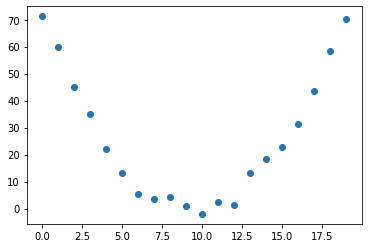

In [4]:
y = torch.randn(20)*3 + 0.75*(x-9.5)**2 + 1
plt.scatter(x,y);

In [0]:
def f(t,params):
  a,b,c=params
  return a*((t-10)**2) + (b*(t-10)) + c

In [6]:
params=torch.randn(3).requires_grad_();params

tensor([ 1.6901, -0.3202,  0.5954], requires_grad=True)

In [7]:
preds=f(x,params);preds

tensor([172.8076, 140.3755, 111.3235,  85.6518,  63.3603,  44.4489,  28.9178,
         16.7669,   7.9962,   2.6057,   0.5954,   1.9654,   6.7155,  14.8458,
         26.3564,  41.2471,  59.5181,  81.1692, 106.2006, 134.6122],
       grad_fn=<AddBackward0>)

In [0]:
def show_preds(x,preds,targ, ax=None):
  if ax is None: ax=plt.subplots()[1]
  ax.scatter(x,targ)
  ax.scatter(x,to_np(preds), color='red')

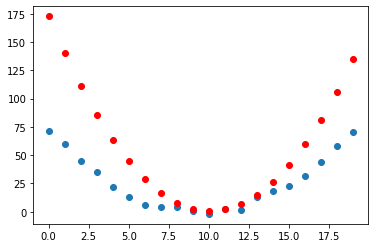

In [9]:
show_preds(x,preds,y)

In [0]:
def mse(preds,target):
  return ((preds-target)**2).mean()

In [11]:
loss=mse(preds,y);loss

tensor(1813.5726, grad_fn=<MeanBackward0>)

In [12]:
loss.backward()
params.grad

tensor([3794.6096, -163.5187,   62.7228])

In [0]:
lr=1e-05
params.data=params.data - (lr*params.grad.data)
params.grad=None

In [14]:
preds=f(x,params)
loss=mse(preds,y)
loss

tensor(1672.2109, grad_fn=<MeanBackward0>)

In [0]:
def fit(x,y,params,print_loss=True):
  preds=f(x,params)
  loss=mse(preds,y)
  if print_loss == True: print(loss)
  loss.backward()
  params.data=params.data - (lr*params.grad.data)
  params.grad=None

  return preds

In [18]:
for i in range(10):
  fit(x,y,params)

tensor(751.3400, grad_fn=<MeanBackward0>)
tensor(694.6481, grad_fn=<MeanBackward0>)
tensor(642.4736, grad_fn=<MeanBackward0>)
tensor(594.4562, grad_fn=<MeanBackward0>)
tensor(550.2646, grad_fn=<MeanBackward0>)
tensor(509.5934, grad_fn=<MeanBackward0>)
tensor(472.1618, grad_fn=<MeanBackward0>)
tensor(437.7119, grad_fn=<MeanBackward0>)
tensor(406.0056, grad_fn=<MeanBackward0>)
tensor(376.8242, grad_fn=<MeanBackward0>)


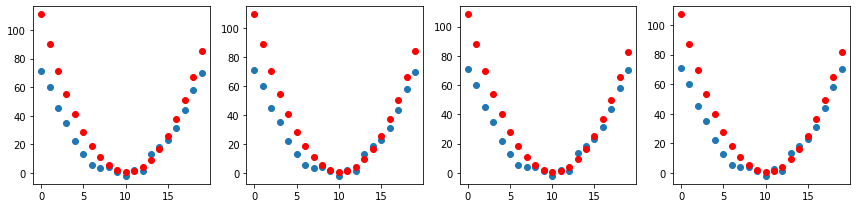

In [24]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: 
  preds=fit(x,y,params,False)
  show_preds(x,preds,y,ax)
plt.tight_layout()

Fitting the covid-19 curve

In [0]:
from google.colab import files
files.upload()

In [27]:
df=pd.read_csv('complete.csv')
df.tail()

,Date,Name of State / UT,Total Confirmed cases (Indian National),Total Confirmed cases ( Foreign National ),Cured/Discharged/Migrated,Latitude,Longitude,Death,Total Confirmed cases
1360,2020-04-27,Telengana,0,0,280,18.1124,79.0193,26,1002
1361,2020-04-27,Tripura,0,0,2,23.9408,91.9882,0,2
1362,2020-04-27,Uttar Pradesh,0,0,289,26.8467,80.9462,29,1868
1363,2020-04-27,Uttarakhand,0,0,28,30.0668,79.0193,0,50
1364,2020-04-27,West Bengal,0,0,105,22.9868,87.8550,20,649


In [0]:
grp=df.groupby(by="Date")
dates=df['Date'].unique()
date_list=[]
for i in dates:
  date_list.append(i)
ddf=pd.DataFrame(date_list, columns=['Date'])

In [0]:
n=1
count_list=[]
labels=['Death','Total Confirmed cases','Cured/Discharged/Migrated']
for l in labels:
  for i in dates:
    d=grp.get_group(i)[l]
    count=d.sum()
    count_list.append(count)
  
  ddf.insert(n,l,count_list)
  n+=1
  count=0
  count_list=[]

In [0]:
#the values on 2020-04-13 were erroneous, hence took the average of the adjacent values
def avg_val(l,val=74):
  new_val=(array(ddf[l])[val-1] + array(ddf[l])[val+1] )/2
  return int(new_val)

In [0]:
change_label=['Death','Total Confirmed cases','Cured/Discharged/Migrated']
for l in change_label:
  ddf.replace(to_replace=array(ddf[l])[74], value= avg_val(l),inplace=True )

In [0]:
ddf=ddf.drop([x for x in range(0,30)]) #dropping inital values were the case count was close to 0

In [92]:
len(ddf['Date'])

59

In [0]:
date=array(ddf['Date'])
cases=array(ddf['Total Confirmed cases'])
cases=torch.tensor(cases)
cases=cases.float()

In [34]:
n_days=torch.arange(0,len(date)).float();
len(date),len(n_days)

(59, 59)

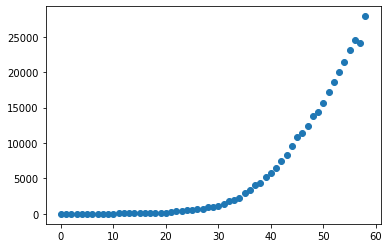

In [35]:
plt.scatter(x=n_days,y=cases)

In [0]:
from sklearn.preprocessing import PolynomialFeatures

In [0]:
poly_feat=PolynomialFeatures(degree=4)

In [0]:
x=n_days.reshape(-1,1)

In [39]:
x.shape

torch.Size([59, 1])

In [0]:
x_poly=poly_feat.fit_transform(x)

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
lin_reg=LinearRegression()

In [43]:
lin_reg.fit(x_poly,cases)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
def plot_pred():
  plt.scatter(x,cases,color='red')
  plt.plot(x, lin_reg.predict(poly_feat.fit_transform(x)), color='blue')
  plt.ylabel('Number of cases')
  plt.xlabel('Number of days')
  plt.title('case rate')
  plt.show()

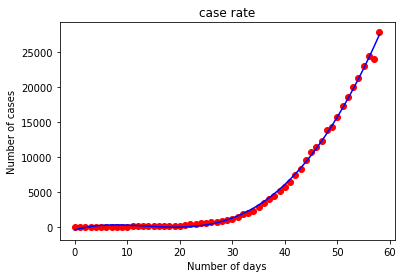

In [45]:
plot_pred()

In [0]:
def pred_case(nday): 
  return int(lin_reg.predict(poly_feat.fit_transform([[nday]])))

In [93]:
pred_case(55)

22668

Extrapolating the fall

In [0]:
up_case=[]
for i in range(60,170):
  new=pred_case(i)
  up_case.append(new)

In [95]:
len(up_case)

110

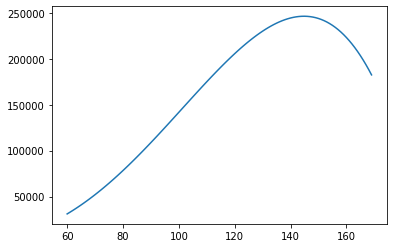

In [108]:
up_date=torch.arange(60,170)
plt.plot(up_date,up_case)

In [104]:
max_case=array(up_case).max();max_case

246438

In [107]:
up_case.index(max_case)

85